In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Propagator Function

def Propagator(N, Lambda, area, z):
    P = np.zeros((N,N), dtype=np.complex)
    for i in range(1, N+1):
        for j in range(1, N+1):
            alpha = Lambda*(i-1-N/2)/area
            beta = Lambda*(j-1-N/2)/area
            
            if((alpha**2+beta**2) <= 1):
                P[i-1][j-1] = np.exp(-(2j*np.pi*z)*(1-(alpha**2+beta**2))/Lambda)
    return P
        

In [4]:
#2D centered Fourier Transfrom

def FT2DC(Input):
    [Nx, Ny] = Input.shape
    
    f1 = np.zeros(Input.shape, dtype=np.complex)
    for i in range(1, Nx+1):
        for j in range(1, Ny+1):
            f1[i-1][j-1] = f1[i-1][j-1] + np.exp(1j*np.pi*(i+j))
            
    FT = np.fft.fft2(f1*Input)
    Output = f1*FT
    return Output
    

In [5]:
#2D centered Inverse Fourier Transfrom

def IFT2DC(Input):
    [Nx, Ny] = Input.shape
    
    f1 = np.zeros(Input.shape, dtype=np.complex)
    for i in range(1, Nx+1):
        for j in range(1, Ny+1):
            f1[i-1][j-1] = np.exp(1j*np.pi*(i+j))
            
    FT = np.fft.ifft2(f1*Input)
    Output = f1*FT
    return Output


In [27]:
# Input Image
Img = Image.open('1.png')

# Parameters 
N = Img.width                               #number of pixels
Lambda = 532*10**(-12)                       #wavelength in meter
object_area = 0.002                         #object area sidelength in meter
z = 0.05                                    #object-to-detector distance in meter


In [20]:
Img.size

(360, 360)

In [29]:
h = Model(51, 0.01, N, Lambda, object_area, z, Img)

In [22]:
#Simulation of inline Hologram with plane wave
######################################################################

def simulate(N, Lambda, object_area, z, Img):
    #Creating object plane transmission function
    object_plane = np.zeros((N,N), dtype=np.complex)
    Img = np.array(Img)
    object_plane = (Img - np.min(Img))/(np.max(Img) - np.min(Img))

    am = np.exp(-1.6*object_plane)
    ph = -3*object_plane

    t=np.zeros((N,N), dtype=np.complex)
    t=am*np.exp(1j*ph)
    ############################################################################
    # Simulating hologram

    prop = Propagator(N, Lambda, object_area, z)
    U = IFT2DC(FT2DC(t)*np.conj(prop))
    hologram = np.absolute(U)**2

    return hologram


In [9]:
# Model for Twin-image Reconstruction

def Model(iterations, p, N, Lambda, object_area, z, Img):
    # Reading hologram
    measured = np.sqrt(simulate(N, Lambda, object_area, z, Img))

    ############################################################

    # Creating initial complex-valued field distribution in the detector plane
    phase = np.zeros((N,N), dtype=np.complex)
    field_detector = measured*np.exp(1j*phase)

    # Creating wave propagation term
    prop = Propagator(N, Lambda, object_area, z)


    #Iterative Reconstruction

    for kk in range(1, iterations):
        field_detector = measured*np.exp(1j*phase)
        
        # Reconstruction of transmission function t
        t = IFT2DC((FT2DC(field_detector))*prop)
        am = np.absolute(t)
        ph = np.angle(t)

        abso = - np.log(am)
        # Constraint in the object domain
        for ii in range(1, N+1):
            for jj in range(1, N+1):
                if ((abso[ii-1][jj-1] < 0)):
                    abso[ii-1][jj-1] = 0
                    ph[ii-1][jj-1] = 0
        
        am = np.exp(-abso)

        t = np.zeros((N,N), dtype=np.complex)

        for ii in range(1, N+1):
            for jj in range(1, N+1):
                t[ii-1][jj-1] = np.complex(am[ii-1][jj-1]*np.cos(ph[ii-1][jj-1]), am[ii-1][jj-1]*np.sin(ph[ii-1][jj-1]))

        field_detector_updated = FT2DC(IFT2DC(t)*np.conj(prop))
        amplitude = np.absolute(field_detector_updated)
        phase = np.angle(field_detector_updated)

        #if(kk%10 == 0):
        #    h = -am
        #    h = (h - np.min(h))/(np.max(h) - np.min(h))
        #    Image.fromarray(h*255).convert('RGB').show()

    return [am, ph]

In [10]:
# ITERATIVE TWIN-IMAGE-FREE RECONSTRUCTION OF IN-LINE HOLOGRAM

####################################################################
iterations = 50
p = 0.01

#####################################################################
# Reading hologram
measured = np.sqrt(simulate(N, Lambda, object_area, z, Img))


# creating initail complex-valued field distribution in the detector plane
phase = np.zeros((N,N), dtype=np.complex)
field_detector = measured*np.exp(1j*phase)

# Creating wave propagation term
prop = Propagator(N, Lambda, object_area, z)

#Iterative Reconstruction


for kk in range(1, iterations):
    field_detector = measured*np.exp(1j*phase)
    
    # Reconstruction of transmission function t
    t = IFT2DC((FT2DC(field_detector))*prop)
    am = np.absolute(t)
    ph = np.angle(t)

    abso = - np.log(am)
    # Constraint in the object domain
    for ii in range(1, N+1):
        for jj in range(1, N+1):
            if ((abso[ii-1][jj-1] < 0)):
                abso[ii-1][jj-1] = 0
                ph[ii-1][jj-1] = 0
    
    am = np.exp(-abso)

    t = np.zeros((N,N), dtype=np.complex)

    for ii in range(1, N+1):
        for jj in range(1, N+1):
            t[ii-1][jj-1] = np.complex(am[ii-1][jj-1]*np.cos(ph[ii-1][jj-1]), am[ii-1][jj-1]*np.sin(ph[ii-1][jj-1]))

    field_detector_updated = FT2DC(IFT2DC(t)*np.conj(prop))
    amplitude = np.absolute(field_detector_updated)
    phase = np.angle(field_detector_updated)

    if(kk%10 == 0):
        h = -am
        h = (h - np.min(h))/(np.max(h) - np.min(h))
        Image.fromarray(h*255).convert('RGB').show()


In [17]:
h = -am
h = (h - np.min(h))/(np.max(h) - np.min(h))
Image.fromarray(h*255).convert('RGB').show()

In [18]:
h = -ph
h = (h - np.min(h))/(np.max(h) - np.min(h))
Image.fromarray(h*255).convert('RGB').show()

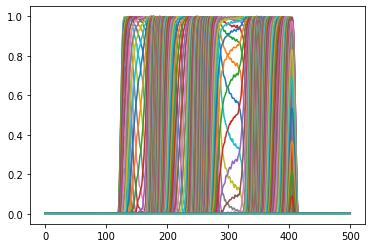

In [16]:
#Plot using matplotlib
plt.plot(h)
plt.show()